<a href="https://colab.research.google.com/github/fatimahaidara/Git-Assignement/blob/master/disastertweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://gizmodo.uol.com.br/wp-content/blogs.dir/8/files/2012/07/twitter-new-logo.png">


**Summary**

1. Introduction
2. Data Importing
3. Exploratory Data Analysis

    3.1 Missing Data
    
    3.2 Target Class Distribution in the Train Dataset
    
    3.3 Text Features
    
    3.4 Top N-Grams and Word Clouds
    
    
4. Cleaning Data
5. TF-IDF Representation

    5.1 Modelling with Logistic Regression
    
    
6. Word Embeddings Representation

    6.1 Modelling with Keras Embedding Layer
    
    6.2 Modelling using Glove
    
    
7. Submission

8. Conclusions

# 1. Introduction

Natural Language Processing (NLP) is a branch of artificial intelligence that deals with the interaction between computers and humans using the natural language. Data can come in many forms: time stamps, sensor readings, images, categorical labels, and so much more. But text is still some of the most valuable data out there. Although the text data contains a lot of information, it is highly unstructured, and that is especially hard when we are trying to build an intelligent system which interprets and understands free flowing natural language just like humans. We need to be able to process and transform noisy, unstructured textual data into some structured, vectorized formats which can be understood by any machine learning algorithm.

Within this context, this project has the goal to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t, with access to a dataset of 10,000 tweets that were hand classified ([Real or Not? NLP with Disaster Tweets](https://www.kaggle.com/c/nlp-getting-started/overview)). 



# 2. Data Importing

**2.1 Train and Test Set Importing**

First, we import the necessary libraries and training and test sets

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import string
import re # Regular expressions

# Sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report


# Visualization
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.stem import PorterStemmer

# Keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing import text
from keras.preprocessing import sequence
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import Adadelta, Adam, RMSprop
from keras.utils import np_utils
from keras.layers.embeddings import Embedding
from keras.layers import Flatten
from keras.layers.recurrent import LSTM, GRU
from keras.layers import GlobalAveragePooling1D,Lambda,Input,GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D,TimeDistributed

Using TensorFlow backend.


In [ ]:
X_train = pd.read_csv('../input/nlp-getting-started/train.csv')

X_test = pd.read_csv('../input/nlp-getting-started/test.csv')

In [ ]:
X_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
X_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# **3. Exploratory Data Analisys**

As we know, we are dealing with textual data from tweets. This is a platform that contains a lot of informal language, so some special care is needed so that we can extract important information to develop a classifier. Thus, in addition to the basic and common exploration of data, we will also look at some special features of text data, such as: number of words contained in tweets, mean word lenght, amount of characters, among others. We will also look at Word Clouds, which are great ways to view the most significant words in texts.


We start by gathering the most basic informations from the datasets, such as their shapes.

In [ ]:
print('Train dataset shape: {}'.format(X_train.shape))
print('Test dataset shape: {}'.format(X_test.shape))

Train dataset shape: (7613, 5)
Test dataset shape: (3263, 4)


We can also take a look into tweets from both classes

In [ ]:
print('Disaster tweet:')
print(X_train.text[0])
print('---------------------------')
print('Normal tweet:')
print(X_train.text[24])

Disaster tweet:
Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
---------------------------
Normal tweet:
LOOOOOOL


**3.1 Missing Data**

In [ ]:
print('Amount of missing data by column in the training dataset')
print(X_train.isnull().sum())
print('------------------------------------')
print('Porcentagem de keywords faltantes no train dataset: {:.3f}%'.format(X_train.keyword.isnull().sum()/X_train.shape[0]*100))
print('Porcentagem de location faltantes no train dataset: {:.3f}%'.format(X_train.location.isnull().sum()/X_train.shape[0]*100))

Amount of missing data by column in the training dataset
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64
------------------------------------
Porcentagem de keywords faltantes no train dataset: 0.801%
Porcentagem de location faltantes no train dataset: 33.272%


In [ ]:
print('Amount of missing data by column in the training dataset:')
print(X_test.isnull().sum())
print('------------------------------------')
print('Porcentagem de keywords faltantes no test dataset: {:.3f}%'.format(X_test.keyword.isnull().sum()/X_test.shape[0]*100))
print('Porcentagem de location faltantes no test dataset: {:.3f}%'.format(X_test.location.isnull().sum()/X_test.shape[0]*100))

Amount of missing data by column in the training dataset:
id             0
keyword       26
location    1105
text           0
dtype: int64
------------------------------------
Porcentagem de keywords faltantes no test dataset: 0.797%
Porcentagem de location faltantes no test dataset: 33.865%


As we can see, a significant amount of the feature location is missing from the dataset. This is a feature that will not be explored in this work. The focus will be on textual data, which has no missing data.

**3.2 Target Class Distribution in the Train Dataset**

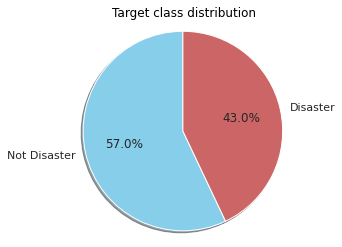

In [ ]:
# Criando a representação, área de plot
fig1, ax1 = plt.subplots(figsize = (4,4))

# Conjunto de dados a ser representado
sns.set(style="darkgrid")
targets = X_train.target.value_counts()
labels = ['Not Disaster', 'Disaster']

# Criando o gŕafico
ax1.pie(targets, labels = labels, autopct = '%1.1f%%', shadow = True, startangle = 90, colors = ['skyblue',(0.8,0.4,0.4)])

# Opções Adicionais
plt.title('Target class distribution')
ax1.axis('equal')

# Mostrando o gŕafico
plt.show()

There is no big discrepancy between the amount of tweets about disasters and the amount of normal tweets. As there is a 57% amount of disaster tweets, we should expect the classifier to have an accuracy at least greater than that.





**3.3 Text Features**

Next, we'll start exploring some specific features of textual data: number of characters in tweets, number of words, mean word lenght and the amount of hashtags. Some distribution charts show such features for tweets classified as disasters and for normal tweets.

In [ ]:
def plot_distplot(disaster_data, non_disater_data, feature):
    fig, axes = plt.subplots(figsize = [5,5], nrows = 1, ncols = 1, dpi = 100)

    sns.set(style = 'darkgrid')
    sns.distplot(non_disater_data, label = 'Not Disaster', ax = axes, color = 'blue')
    sns.distplot(disaster_data, label = 'Disaster', ax = axes, color = 'red')
    axes.set_xlabel('')
    axes.tick_params(axis='x', labelsize=12)
    axes.tick_params(axis='y', labelsize=12)
    axes.legend()
    axes.set_title(f'{feature} Distribution in Training set')

    plt.show()


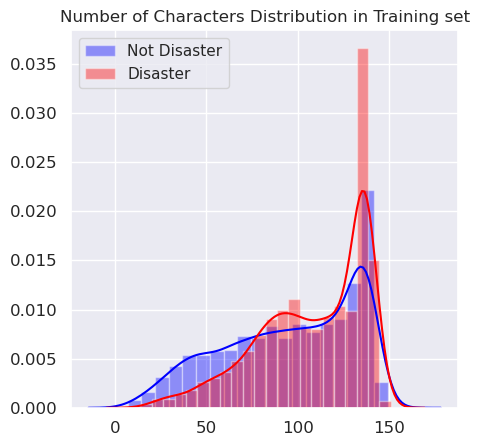

In [ ]:
# Number of characteres in tweets
disaster_char_len = X_train[X_train['target']==1]['text'].map(lambda x: len(str(x)))
non_disaste_char_len = X_train[X_train['target']==0]['text'].map(lambda x: len(str(x)))

plot_distplot(disaster_char_len,non_disaste_char_len, 'Number of Characters' )

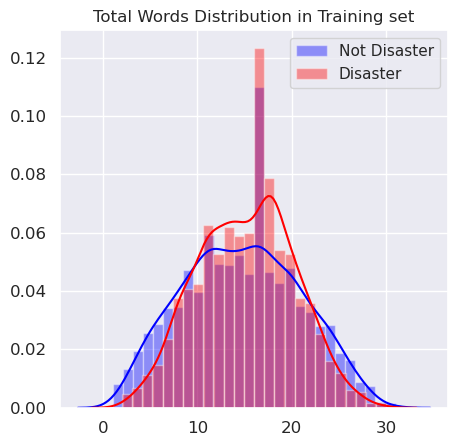

In [ ]:
# Number of words
total_words_disaster = X_train[X_train.target == 1]['text'].map(lambda x: len(list(x.split())))

total_words_non_disaster = X_train[X_train.target == 0]['text'].map(lambda x: len(list(x.split())))

plot_distplot(total_words_disaster,total_words_non_disaster, feature = 'Total Words')

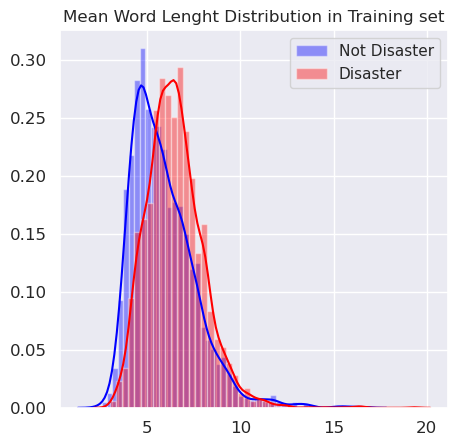

In [ ]:
# Mean word lenght

mean_word_disaster = X_train[X_train.target == 1]['text'].map(lambda x: np.mean([len(item) for item in list(x.split())]))
mean_word_non_disaster = X_train[X_train.target == 0]['text'].map(lambda x: np.mean([len(item) for item in list(x.split())]))

plot_distplot(mean_word_disaster,mean_word_non_disaster, feature = 'Mean Word Lenght' )

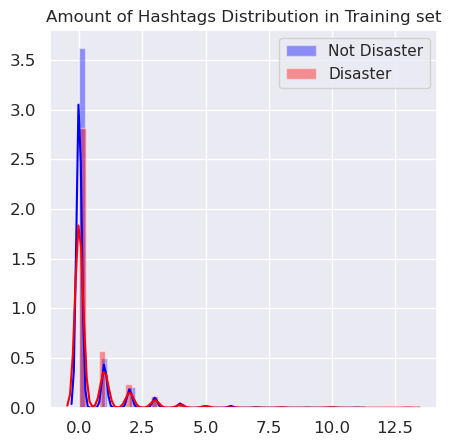

In [ ]:
# Amount of hashtags

hashtags_disaster = X_train[X_train.target == 1]['text'].map(lambda x: str(x).count('#'))
hashtags_not_disaster = X_train[X_train.target == 0]['text'].map(lambda x: str(x).count('#'))

fig, axes = plt.subplots(figsize = [5,5], nrows = 1, ncols = 1, dpi = 100)

sns.set(style = 'darkgrid')
sns.distplot(hashtags_not_disaster, label = 'Not Disaster', ax = axes, color = 'blue', kde_kws = {'bw':0.1})
sns.distplot(hashtags_disaster, label = 'Disaster', ax = axes, color = 'red',kde_kws = {'bw':'scott'})
axes.set_xlabel('')
axes.tick_params(axis='x', labelsize=12)
axes.tick_params(axis='y', labelsize=12)
axes.legend()
axes.set_title('Amount of Hashtags Distribution in Training set')

plt.show()

**Findings:**
* In general, the distribution of these features for the two classes of tweets is quite similar and adds little information to classification models. The classification of tweets should be strongly based on NLP techniques.

* The number of characters, the number of words and the mean word lenght of disaster tweets is slightly greater than for normal tweets. This is consistent with a more formal language used in disaster tweets, which could be expected for messages of this nature.

**3.4 Top Words and Word Clouds**

We can also see which words appear more for each of the tweet classes, both by bar graphs and word clouds. We hope that this will give us a sense of the most used vocabulary for each of the classes. If we notice a big difference between words used in each type of tweet, we can have more confidence in a good classification model.

We start by defining a function that uses the CountVectorizer class from the sklearn package. This class allows us to build the Document-Term Matrix representation. The document-term matrix or term-document matrix is a mathematical matrix that describes the frequency of terms that occur in a collection of documents. In a document-term matrix, rows correspond to documents in the collection and columns correspond to terms. Thus, each of the text data is represented by the amount of unique words that it contains. This representation is also called bag of words and it will help us to extract the top N-Grams from the text. An n-gram is a contiguous sequence of n items from a given sample of text or speech. The items can be phonemes, syllables, letters, words or base pairs according to the application

If we had two sentences:

* D1 = I like databases
* D2 = I hate databases

Then, the document-term matrix for this would be

In [ ]:
data = {'I':[1,1], 'like': [1,0], 'hate': [0,1], 'databases': [1,1]}
DTM_Example = pd.DataFrame(data, index = ['D1', 'D2'])

DTM_Example

,I,like,hate,databases
D1,1,1,0,1
D2,1,0,1,1


We also define two more functions: one to return the k top N-Grams given a DTM; and finally one to show graph bars of these top k N-Grams for both classes of tweets. 

In [ ]:
def document_term_matrix(dataframe, ngrams = (1,1)):
    """
    Returns a DataFrame that is a DTM with the specified N-Grams and the text data as input
    """
    cv = CountVectorizer(stop_words = "english", ngram_range=ngrams, min_df = 5)
    data_cv = cv.fit_transform(dataframe.text) #Learn the vocabulary dictionary and return document-term matrix.
    
    # data_cv.toarray() returns an array representation of the bag of words
    # get_feature_names returns all the words in the corpus in array-like form
    data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names()) # create the dtm_dataframe
    
    # reset the index to match de input dataframe index
    data_dtm.index = dataframe.index
    data_dtm['target_label'] = X_train.target
    return data_dtm




In [ ]:
# Top words for each category

def top_ngrams(k, df):
    '''
    Returns the k top commom ngrams for disaster and for not disaster tweets, given a DTM.
    '''
    
    # Not Disaster
    
    # Get only the normal tweets
    target_label_df_ndisaster = pd.DataFrame(df[df['target_label'] == 0])
    
    # Aggregate the top ngrams
    word_counts_ndisaster = [target_label_df_ndisaster[column].sum() for column in target_label_df_ndisaster.columns]
    target_label_df_ndisaster = pd.DataFrame(word_counts_ndisaster, target_label_df_ndisaster.columns)
    
    # Sort from descending order
    top_words_ndisaster = target_label_df_ndisaster[0].sort_values(ascending = False)[0:k]
    
    
    # Disaster
    
    # Get only the disaster tweets
    target_label_df_disaster = pd.DataFrame(df[df['target_label'] == 1]).drop('target_label', axis = 1)
    
    # Aggregate the top ngrams
    word_counts_disaster = [target_label_df_disaster[column].sum() for column in target_label_df_disaster.columns]
    target_label_df_disaster = pd.DataFrame(word_counts_disaster, target_label_df_disaster.columns)
    
    # Sort from descending order
    top_words_disaster = target_label_df_disaster[0].sort_values(ascending = False)[0:k]
    
    return top_words_ndisaster, top_words_disaster
    
    


In [ ]:
def plot_top_ngrams(not_disaster_ngrams, disaster_ngrams):
    """
    Plots a bar graph showing the top n-grams for disaster and non disaster tweets
    """
    # Gets the N of N-gram
    n_gram = len((not_disaster_ngrams.index[0]).split())
    n_gram_dict = {1: 'Words', 2: 'Bigrams', 3: 'Trigrams'}
    
    
    fig, axes = plt.subplots(figsize = [24,12], nrows = 1, ncols = 2)
    sns.set(style="darkgrid")
    sns.barplot(y = not_disaster_ngrams.index, x = not_disaster_ngrams.values, ax = axes[0])
    sns.barplot(y = disaster_ngrams.index, x = disaster_ngrams.values, ax = axes[1])

    axes[0].set_title(f'Top Non Disaster {n_gram_dict[n_gram]}')
    axes[0].set_xlabel(f'{n_gram_dict[n_gram]} Count')
    axes[0].set_ylabel(f'{n_gram_dict[n_gram]}')

    axes[1].set_title(f'Top Disaster {n_gram_dict[n_gram]}')
    axes[1].set_xlabel(f'{n_gram_dict[n_gram]} Count')
    axes[1].set_ylabel(f'{n_gram_dict[n_gram]}')

    plt.tight_layout()
    plt.show()

In [ ]:
def generate_display_wordclouds(dataframe):
    full_text_non_disaster = ''.join(dataframe[dataframe['target'] == 0].text)
    full_text_disaster = ''.join(dataframe[dataframe['target'] == 1].text)

        
    wc_not_disaster = WordCloud(background_color="white", colormap="Dark2",
                   max_font_size=150, random_state=42)
    
    wc_disaster = WordCloud(background_color="white", colormap="Dark2",
                   max_font_size=150, random_state=42)
    
    wc_not_disaster.generate(full_text_non_disaster)
    wc_disaster.generate(full_text_disaster)
    
    
    fig, axes = plt.subplots(figsize = [20,8], nrows = 1, ncols = 2)
    
    axes[0].imshow(wc_not_disaster, interpolation = 'bilinear')
    axes[1].imshow(wc_disaster, interpolation = 'bilinear')
    axes[0].axis("off")
    axes[1].axis("off")
    
    
    axes[0].set_title('Not Disaster')
    axes[1].set_title('Disaster')
    
    
    
    
    

    

We now use these functions to create a DTM from the raw text input data, to plot the top Words (1-Gram) and to generate word clouds for both classes of tweets.

In [ ]:
# Document Term Matrix from the original input
raw_data_dtm = document_term_matrix(X_train)

# Get the top disaster and not disaster words
top_ndisaster_words, top_disaster_words = top_ngrams(20, raw_data_dtm)


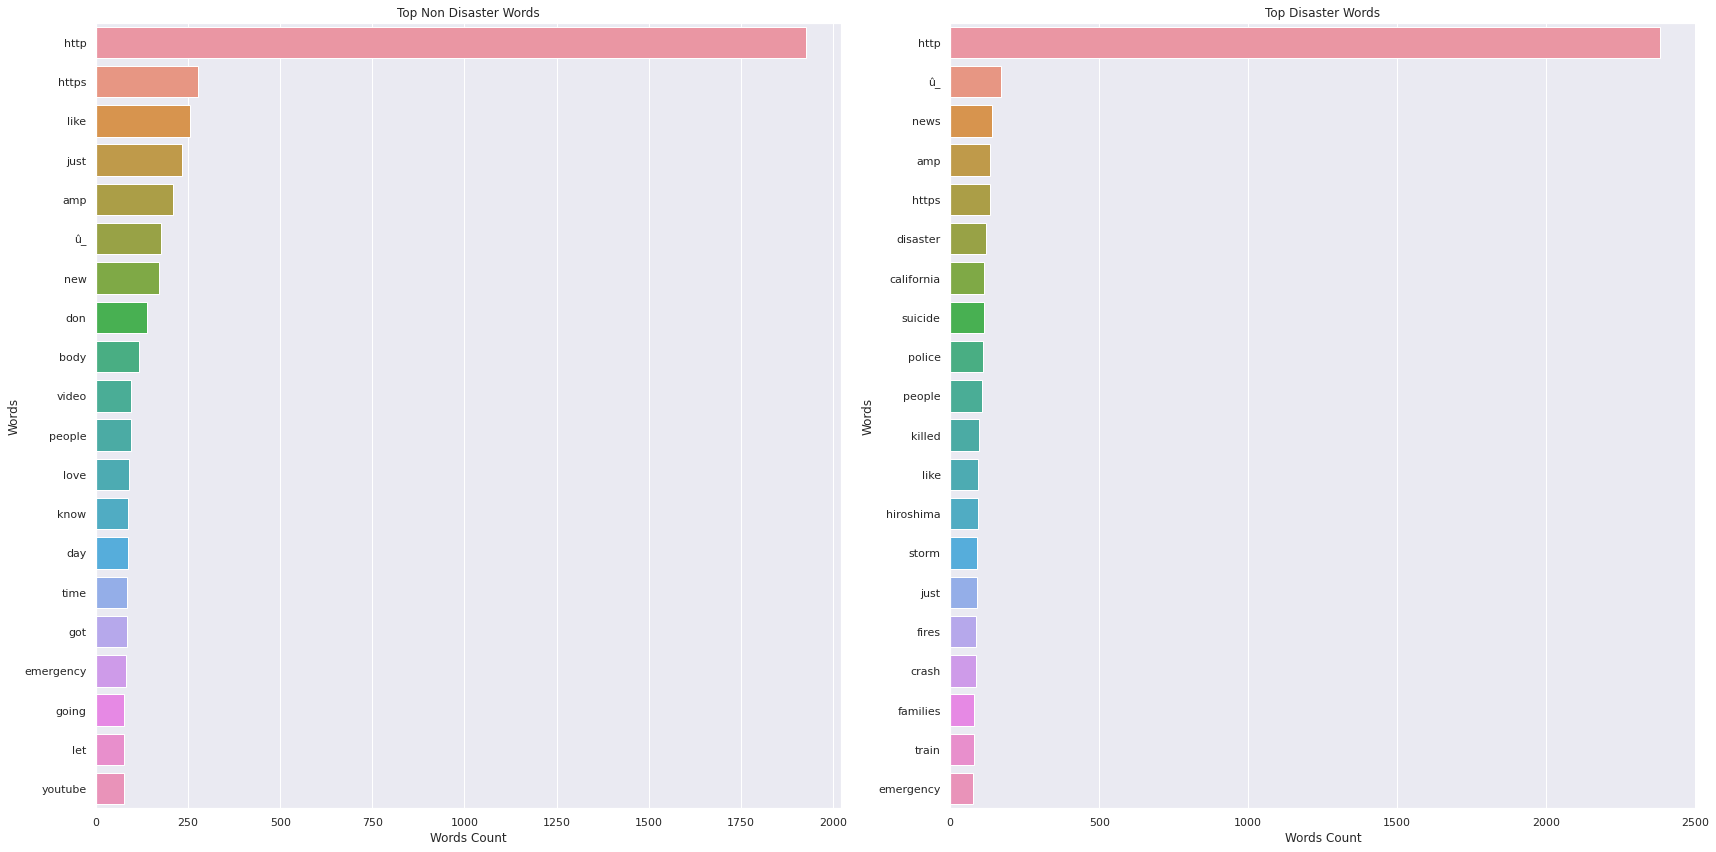

In [ ]:

# Plot the top words
plot_top_ngrams(top_ndisaster_words,top_disaster_words)


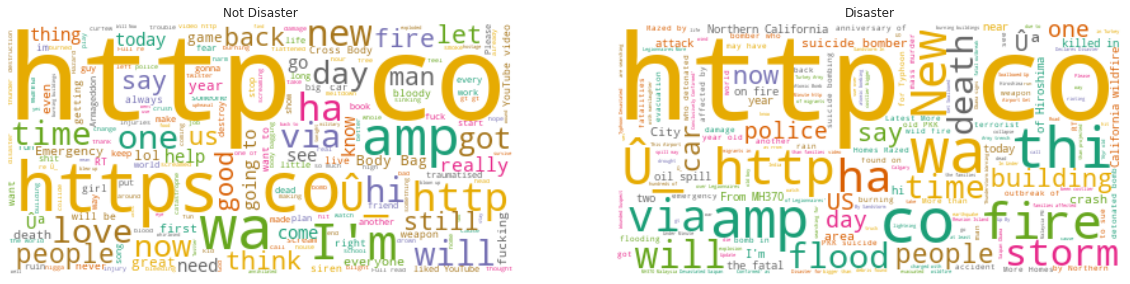

In [ ]:
# Generate the raw data word clouds
generate_display_wordclouds(X_train)

**Findigs**

* Both the most common words and the word clouds indicates to us that a lot of cleaning will be necessary to handle these text entries.

* Among the most common words in both classes, the word 'http' stands out a lot. This is due to the large amount of links present in the tweets. Therefore, when cleaning data, we must remove such links.

* Some words like 'amp', 'wa', 'û_' appear a lot in both classes of tweets and add little information so that we can distinguish the content of the texts.

* Some words are repeated between both classes and we can test removing them from the set of texts.



# 4. Cleaning Data

Text data is well known for being highly unstructured. Because of that, one the most important steps in building NLP projects is cleaning the data. The number one rule we follow is: “Your model will only ever be as good as your data.”

The following steps were taken to clean the texts:

* Removal of words that are not relevant, such as “@” twitter mentions or urls
* Convertion of all characters to lowercase, in order to treat words such as “hello”, “Hello”, and “HELLO” the same
* Removal of words containing non alphanumeric characters in it
* Removal of all of the punctuation
* Removal of urls
* Expansion of contractions such as expanding we'll into we will. Adapted from https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python.
* Expansion of abreviation. For example, 'ppl' is transformed into people. Adapted from https://www.kaggle.com/nmaguette/up-to-date-list-of-slangs-for-text-preprocessing
* Removal of unnecesssary spacings, line breaking and special characters


In [ ]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [ ]:
contractions = { 
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has",
"i'd": "i had",
"i'd've": "i would have",
"i'll": "i shall",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it had ",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so is",
"that'd": "that had",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

In [ ]:
def fix_abreviations(text):
    """
    Expand te abreviations (slangs) into its formal word
    """
    words = text.split(' ')
    clean_text = []
    for word in words:
        clean_text.append(abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word)
    
    clean_text = ' '.join(clean_text)
    return clean_text

def fix_contractions(text):
    """
    Expands the english contractions
    """
    words = text.split(' ')
    clean_text = []
    for word in words:
        clean_text.append(contractions[word.lower()] if word.lower() in contractions.keys() else word)
    
    clean_text = ' '.join(clean_text)
    
    return clean_text

def clean_data(text):
    text = text.lower()
    
    # Fix contractions
    text = fix_contractions(text)
    
    # Fix abreviations
    
    text = fix_abreviations(text)
    
    
    text = re.sub('[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]', '', text) # remove punctuations
    text = re.sub(r'\n', ' ', text)  # remove line breaks
    text = re.sub(r'https?://\S+', '', text) # remove links
    text = re.sub(r'\s+', ' ', text) # remove unnecessary spacings
    text = re.sub(r'\w*\d\w*', '', text) # remove words containing numbers

    # Remove Special characters -  adapted from https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert#3.-Target-and-N-grams
    text = re.sub(r"û_", "", text)
    text = re.sub(r"ûò", "", text)
    text = re.sub(r"ûòåê", "", text)
    text = re.sub(r"ûó", "", text)
    text = re.sub(r"ûó", "", text)
    text = re.sub(r"û÷", "", text)
    text = re.sub(r"ûª", "", text)
    text = re.sub(r"å_", "", text)
    text = re.sub(r"ûï", "", text)
    text = re.sub(r"åê", "", text)
    text = re.sub(r"åè", "", text)
    text = re.sub(r"å¨", "", text)
    text = re.sub(r"åÇ", "", text)
    text = re.sub(r"ìñ", "", text)
    text = re.sub(r"ìñ", "", text)
    text = re.sub(r"ìü", "", text)
    text = re.sub(r"ââ", "", text)
    text = re.sub(r"åç", "", text)

    
    
    return text
    


After defining the cleaning fuctions, we can apply that to the input text data.

In [ ]:
clean_df = pd.DataFrame(X_train['text'].apply(clean_data))
clean_df['target'] = X_train.target

clean_df.head()

,text,target
0,our deeds are the reason of this earthquake ma...,1
1,forest fire near la ronge sask canada,1
2,all residents asked to shelter in place are be...,1
3,people receive wildfires evacuation orders in...,1
4,just got sent this photo from ruby alaska as s...,1


Again, we would like to check a few tweets from each class, before and after the cleaning function.

In [ ]:
print('Disaster tweets cleaned')
print('Before:\n {} \n After:\n {}'.format(X_train.text[5], clean_df.text[5]))
print('##############################################')
print('Before:\n {} \n After:\n {}'.format(X_train.text[8], clean_df.text[8]))
print('##############################################')
print('Before:\n {} \n After:\n {}'.format(X_train.text[12], clean_df.text[12]))
print('##############################################')
print('---------------------------------------------')
print('Normal tweets cleaned')
print('Before:\n {} \n After:\n {}'.format(X_train.text[30], clean_df.text[30]))
print('##############################################')
print('Before:\n {} \n After:\n {}'.format(X_train.text[34], clean_df.text[34]))
print('##############################################')
print('Before:\n {} \n After:\n {}'.format(X_train.text[42], clean_df.text[42]))


Disaster tweets cleaned
Before:
 #RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires 
 After:
 rockyfire update california hwy  closed in both directions due to lake county fire cafire wildfires
##############################################
Before:
 There's an emergency evacuation happening now in the building across the street 
 After:
 there is an emergency evacuation happening now in the building across the street
##############################################
Before:
 #raining #flooding #Florida #TampaBay #Tampa 18 or 19 days. I've lost count  
 After:
 raining flooding florida tampabay tampa  or  days i have lost count 
##############################################
---------------------------------------------
Normal tweets cleaned
Before:
 The end! 
 After:
 the end
##############################################
Before:
 Crying out for more! Set me ablaze 
 After:
 crying out for more set me ablaze
#####################

We can then look again at the top N-Grams and to the word clouds to see if the classes of tweets now have a different vocabulary. This time, we will also see the bigrams and trigrams.

In [ ]:
# Document Term Matrix cleaned
clean_data_dtm = document_term_matrix(clean_df)
dtm_bigrams = document_term_matrix(clean_df, ngrams = (2,2))
dtm_trigrams = document_term_matrix(clean_df, ngrams = (3,3))


# Get the top disaster and not disaster words
top_ndisaster_words, top_disaster_words = top_ngrams(20, clean_data_dtm)

top_ndisaster_bigrams, top_disaster_bigrams = top_ngrams(20, dtm_bigrams)

top_ndisaster_trigrams, top_disaster_trigrams = top_ngrams(20, dtm_trigrams)



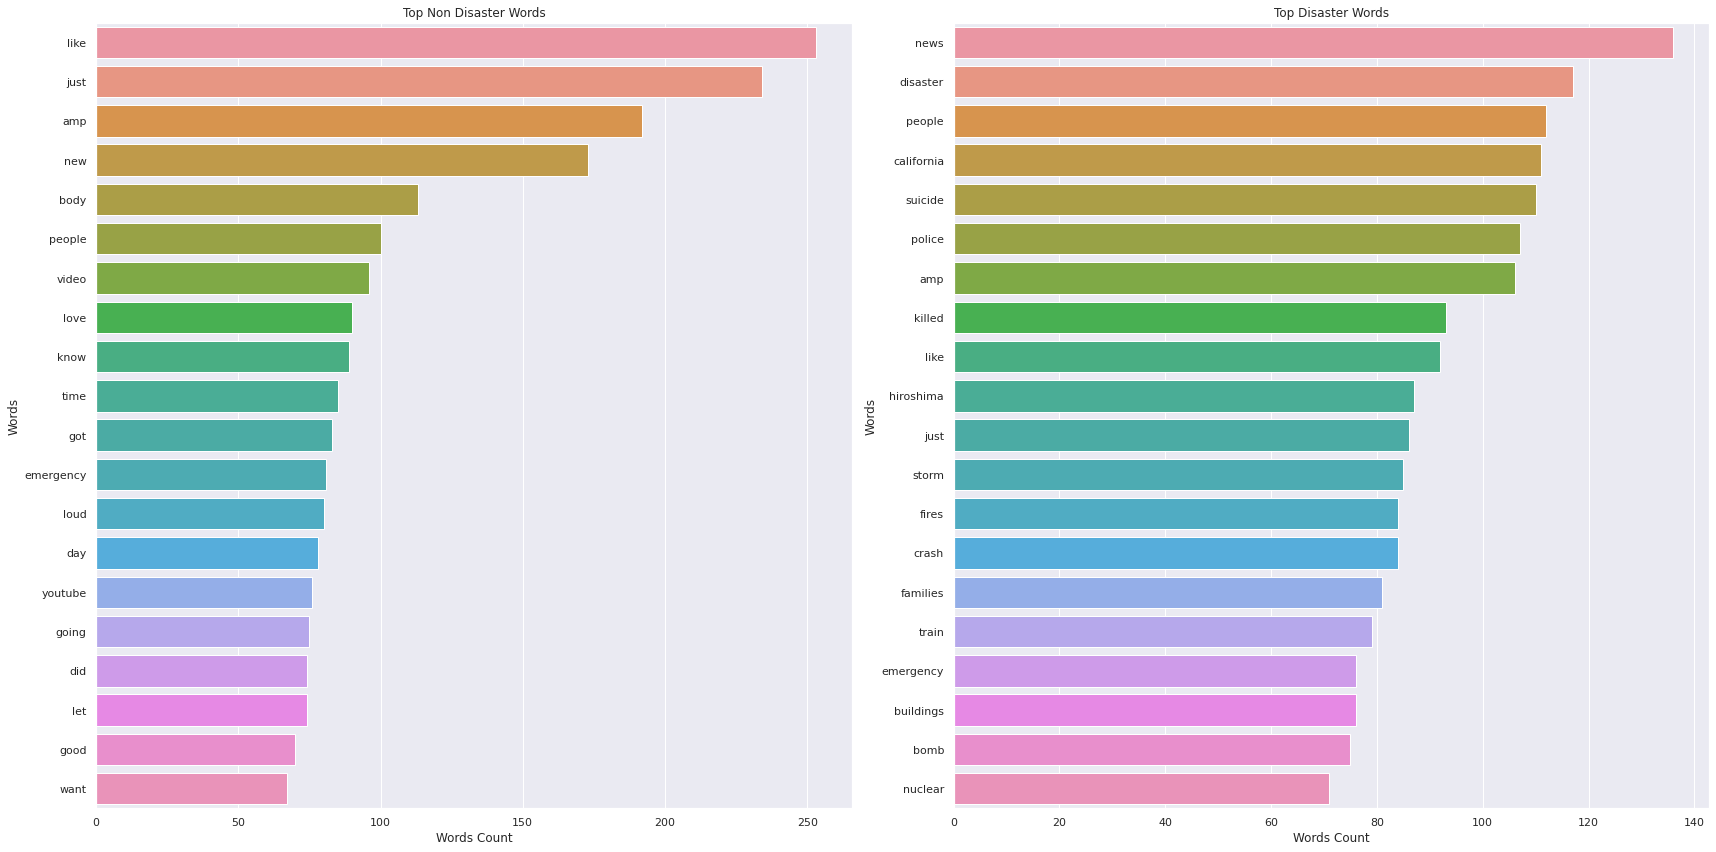

In [ ]:
plot_top_ngrams(top_ndisaster_words,top_disaster_words)

* There are still a few top words that are shared between the two classes. Altough, we got a lot more of meaning from the top 20 words.

* The most used words for disaster tweets reflect real tragedies, such as 'disaster', 'suicide', 'fires', among othes

* The most used words for normal tweets are much more 'commom', such as 'love', 'video', 'youtube'.

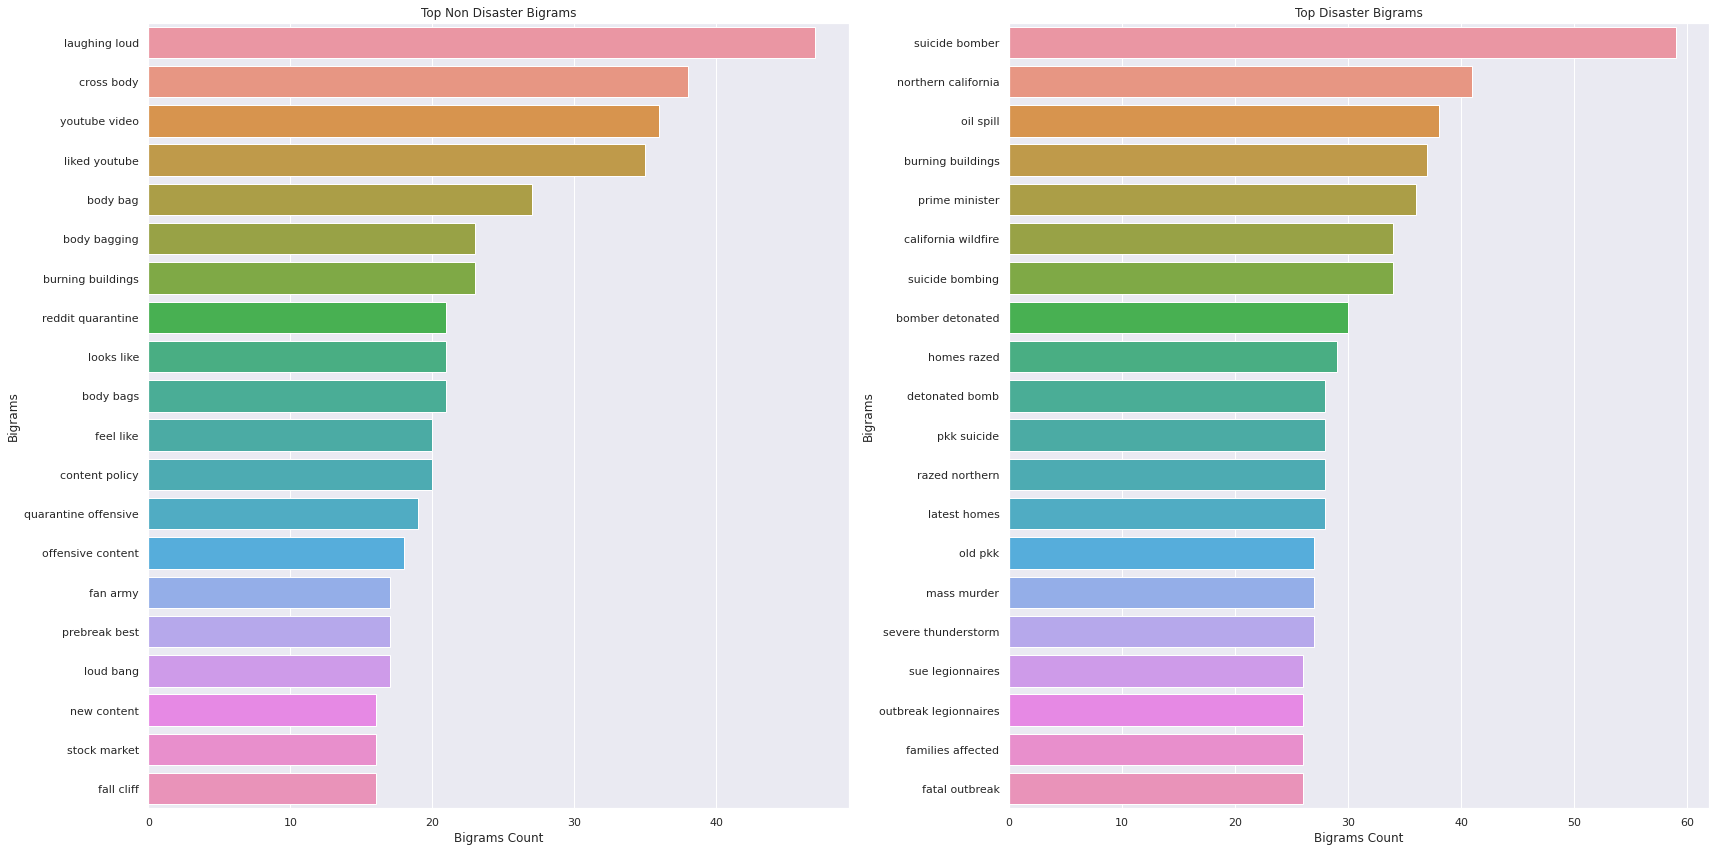

In [ ]:
plot_top_ngrams(top_ndisaster_bigrams,top_disaster_bigrams)

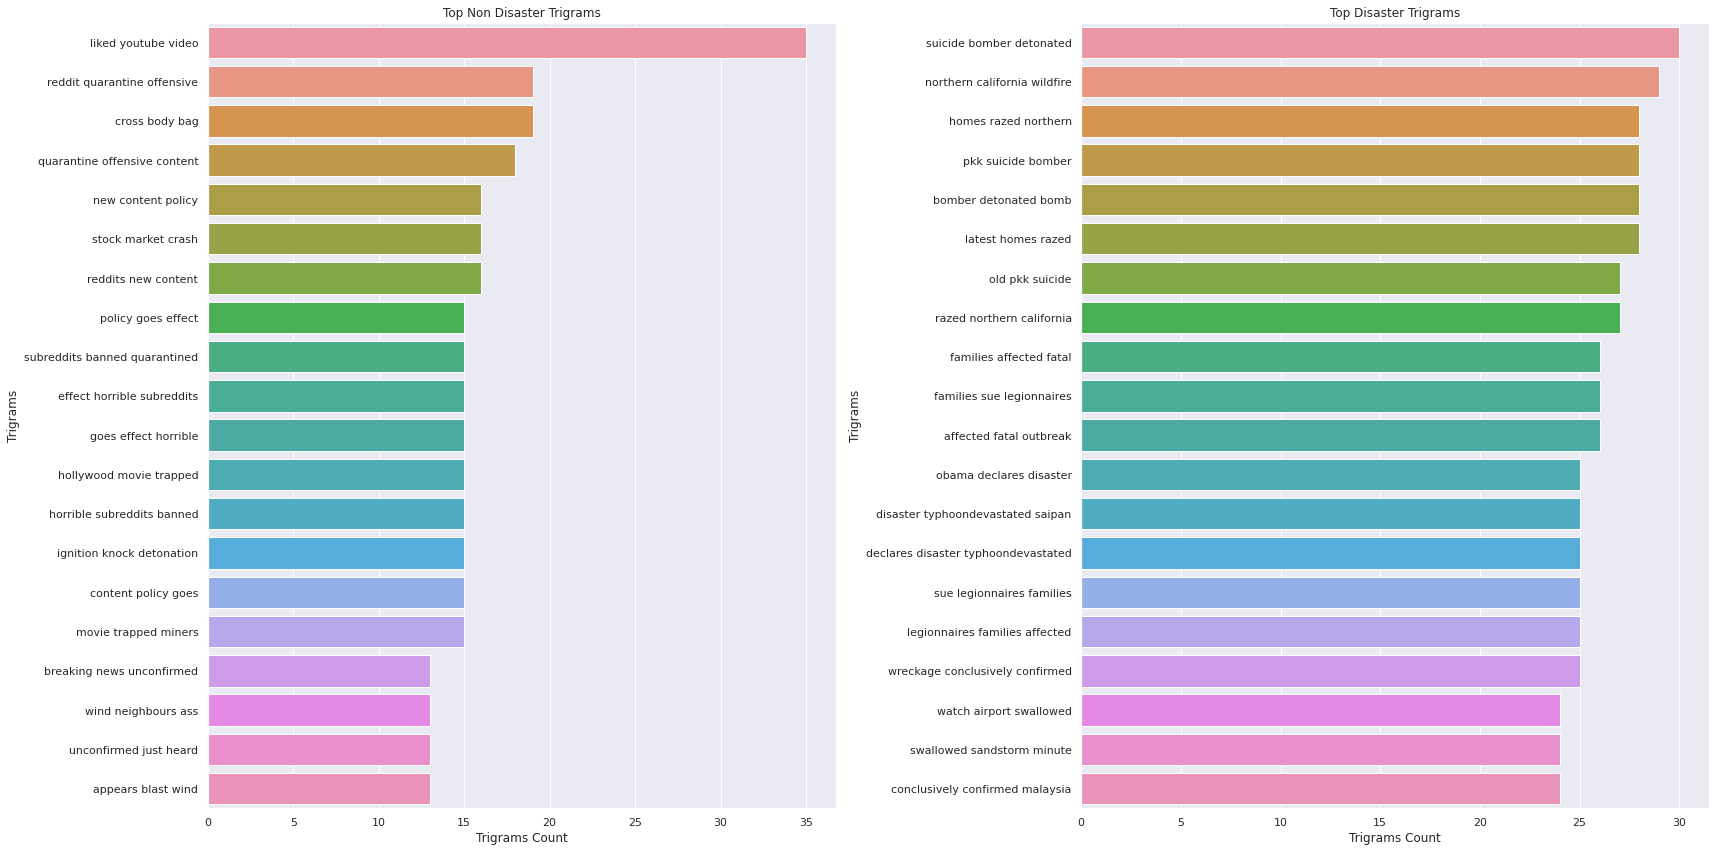

In [ ]:
plot_top_ngrams(top_ndisaster_trigrams,top_disaster_trigrams)

* There are no top bigrams or trigrams in commom between both classes becaus the context is much clearer.

* Again we can see that the top bigrams and top trigrams reflect the nature of their text. Bigrams such as 'suicide bomber' or 'california wildfire' clearly are about tragedies. Trigrams such as 'liked youtube video' clearly are not.

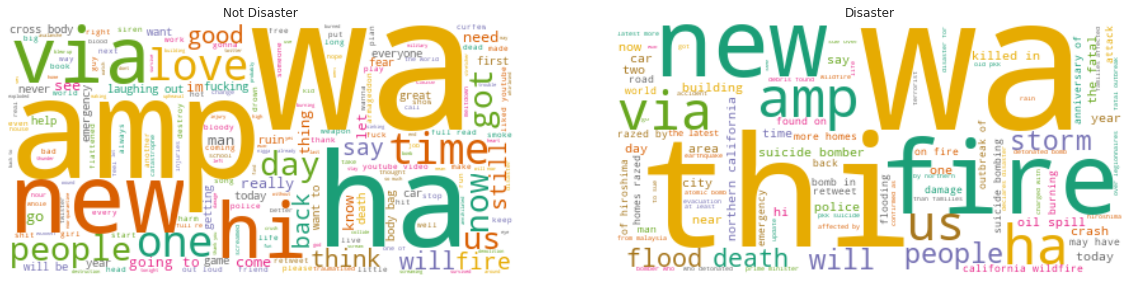

In [ ]:
generate_display_wordclouds(clean_df)

* The words clouds point to a much clearer difference in the vocabulary of the two classes of tweets. However, there are still some words of apparently little importance, such as 'wa' and 'amp'. We can then consider removing these words, as well as some other words in common.


In [ ]:
def remove_words_in_commom(top_disaster_words, top_ndisaster_words):
    top_disaster_words = top_disaster_words.index
    top_ndisaster_words = top_ndisaster_words.index

    remove_word = [word for word in top_ndisaster_words if word in top_disaster_words]
    remove_word = remove_word[0:-1]
    remove_word.append('wa')
    return remove_word

# 5. TF-IDF Representation

Now that we have a much cleaner corpus than the initial data entry, we can apply NLP techniques so that machine learning models can perform the task of classifying tweets.

We can build a vocabulary of all the unique words in our dataset, and associate a unique index to each word in the vocabulary. Each sentence is then represented as a list that is as long as the number of distinct words in our vocabulary. At each index in this list, we mark how many times the given word appears in our sentence. This is called a Bag of Words model, since it is a representation that completely ignores the order of words in our sentence.

The TD-IDF is a slight improvement to the Bag of Words models. TFIDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. It is often used as a weighting factor in searches of information retrieval, text mining, and user modeling. The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general. tf–idf is one of the most popular term-weighting schemes today.

To apply the TF-IDF representation we will follow the following steps:

* Tokenize the texts: this is a process of breaking the piece of texts into many pieces, such as sentences or words

* Removal of stop words: stop words are very commom words in texts and they add little extra information to the messages. In english, commom stop words are: 'for', 'to', 'the'.

* Lemmatize the text: lemmatization refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base or dictionary form of a word, which is known as the lemma.

<img src="https://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1539984207/stemminglemmatization_n8bmou.jpg" width="600px">

The following function returns a clean, tokenized and lemmatized text.

In [ ]:
def preprocessing(text):
    # clean the text using the clean_data function
    preprocessed_text = clean_data(text)
    
    #  tokenizes the sentences into words based on whitespaces
    tokens = [word for sent in nltk.sent_tokenize(preprocessed_text) for word in nltk.word_tokenize(sent)]
    stopwds = stopwords.words('english')
    tokens = [token for token in tokens if token not in stopwds]
    
    
    # Lemmatization
    tagged_corpus = pos_tag(tokens)
    Noun_tags = ['NN','NNP','NNPS','NNS']
    Verb_tags = ['VB','VBD','VBG','VBN','VBP','VBZ']
    lemmatizer = WordNetLemmatizer()
    
    # The following function, prat_lemmatize, has been created only for the reasons of mismatch 
    # between the pos_tag function and intake values of lemmatize function. 
    def prat_lemmatize(token, tag):
        if tag in Noun_tags:
            return lemmatizer.lemmatize(token,'n')
        elif tag in Verb_tags:
            return lemmatizer.lemmatize(token,'v')
        else:
            return lemmatizer.lemmatize(token,'n')
     
    pre_proc_text =   " ".join([prat_lemmatize(token,tag) for token,tag in tagged_corpus])
    return pre_proc_text
    

**5.1 Modelling with Logistic Regression**

As a  general good practice we'll start with a simple tool that can solve the task. Whenever it comes to classifying data, a common favorite for its versatility and explainability is Logistic Regression. It is very simple to train and the results are interpretable as you can easily extract the most important coefficients from the model.

We split our data in to a training set used to fit our model and a test set to see how well it generalizes to unseen data. 

In [ ]:
# Getting only the target column
y = X_train.target 

# Getting only the text column

X = X_train.text

# Splitting the data into training and validation
x_train, x_test, y_train, y_test = train_test_split(
                                    X, y, test_size=0.33, random_state=42)

Next, we apply the preprocessing function to the train and test inputs. Then, we transform it into a TF-IDF matrix and train the logistic regression model

In [ ]:
# Preprocessing train and test sets
x_train = x_train.apply(preprocessing)
x_test = x_test.apply(preprocessing)

# Creating a TfidfVectorizer object.
# words and bigrams that appear less then 5 times in the vocabulary dont add a lot of information and are removed
tfidf = TfidfVectorizer(min_df = 5, ngram_range = (1,2), stop_words = 'english')

# Learning the vocabulary from the train set
text_vec = tfidf.fit_transform(x_train)

# Transforming the test set into a TF-IDF representation
test_vec_test = tfidf.transform(x_test)

# Getting the results dataframes
x_train = pd.DataFrame(text_vec.toarray(), columns = tfidf.get_feature_names())
x_test = pd.DataFrame(test_vec_test.toarray(), columns = tfidf.get_feature_names())

Finally, we can create a logistic regression model to train and predict the data. 

In [ ]:
lr = LogisticRegression(solver='liblinear', random_state=777)

# This estimator scales and translates each feature individually such that it is in the given range on the training set, e.g. between zero and one.
scaler = MinMaxScaler()
pipeline = Pipeline([('scale',scaler), ('lr', lr),])

pipeline.fit(x_train, y_train)

print ('Training accuracy: %.4f' % pipeline.score(x_train, y_train))
print ('Test accuracy: %.4f' % pipeline.score(x_test, y_test))


Training accuracy: 0.8716
Test accuracy: 0.7847


As we can see, we have a significant amount of overfitting with this model. Altough we already got a test accuracy near 80%. 

Altough the TF-IDF representation is an effective method for extracting features from text, due to the inherent nature of the model being just a bag of unstructured words, we lose additional information like the semantics, structure, sequence and context around nearby words in each text document.

This gives enough motivation to try a different approach: word embeddings.

# 6. Word Embeddings Representation

To overcome the shortcomings of losing out semantics and feature sparsity in bag of words model based features, we need to make use of Vector Space Models (VSMs) in such a way that we can embed word vectors in this continuous vector space based on semantic and contextual similarity.

Embeddings (in general, not only in Keras) are methods for learning vector representations of categorical data. They are most commonly used for working with textual data. Word2vec and GloVe are two popular frameworks for learning word embeddings. What embeddings do, is they simply learn to map the one-hot encoded categorical variables to vectors of floating point numbers of smaller dimensionality then the input vectors. For example, one-hot vector representing a word from vocabulary of size 50 000 is mapped to real-valued vector of size 100. Then, the embeddings vector is used for whatever you want to use it as features.


Although there are many packages to handle representation in word embeddings, we will bring you two very common approaches. First, we will develop a neural network with the first layer being an embedding layer. With embeddings learned as a layer of a neural network, the network may be trained to predict whatever you want. For example, you can train your network to predict sentiment of a text. In such case, the embeddings would learn features that are relevant for this particular problem. As a side effect, they can learn also some general things about the language, but the network is not optimized for such task.

Then, we will use the pre trained Glove model for embedding. GloVe model stands for Global Vectors which is an unsupervised learning model which can be used to obtain dense word vectors similar to Word2Vec. The glove has a word vector trained from 2 bilions tweets, with a vocabulary of 1.2 milion terms and representations in 25, 50, 100 or 200 dimensions.



**6.1 Modelling with Keras Embedding Layer**

Once again, we start by splitting the data into a training and a test set

In [ ]:
# Splitting the data into training and validation
x_train, x_test, y_train, y_test = train_test_split(
                                    X, y, test_size=0.33, random_state=42)

Instead of applying the traditional preprocessing steps, we'll only apply the clean_data function. Since  the embedding representation can capture the semantics of the texts, removing stop words actually makes the model perform worse.

In [ ]:
# Cleaning the train and test sets
x_train = pd.DataFrame(x_train.apply(clean_data))
x_test = pd.DataFrame(x_test.apply(clean_data))


The keras embedding requires that the input data be integer encoded, so that each word is represented by a unique integer. This data preparation step can be performed using the Tokenizer API also provided with Keras.

The Embedding layer is initialized with random weights and will learn an embedding for all of the words in the training datase. It must specify 3 arguments:


* input_dim: This is the size of the vocabulary in the text data. For example, if your data is integer encoded to values between 0-10, then the size of the vocabulary would be 11 words.
* output_dim: This is the size of the vector space in which words will be embedded. It defines the size of the output vectors from this layer for each word. For example, it could be 32 or 100 or even larger. Test different values for your problem.
* input_length: This is the length of input sequences, as you would define for any input layer of a Keras model. For example, if all of your input documents are comprised of 1000 words, this would be 1000.

By looking at the graphics at section 3, we can see that the vast majority of tweets has a maximum word count of 25. Thus, we will use 25 as the max lenght of the input text data.

In [ ]:
# Creating the tokenizer object
tokenizer = text.Tokenizer()

# Leaning the toknes
tokenizer.fit_on_texts(x_train.text)

# Size of the vocabulary
vocab_size = len(tokenizer.word_index) + 1

# Applying the tokenization 
encoded_docs = tokenizer.texts_to_sequences(x_train.text)
encoded_docs_test = tokenizer.texts_to_sequences(x_test.text)

max_lenght = 25

# Padding the documents
padded_docs = sequence.pad_sequences(encoded_docs, maxlen= max_lenght, padding = 'post')
padded_docs_test = sequence.pad_sequences(encoded_docs_test, maxlen= max_lenght, padding = 'post')

In [ ]:
padded_docs.shape

(5100, 25)

Finally, we apply a simple neural network model to train the data. In addition to the embedding layer, we will also add a LSTM layer.

A LSTM network is a kind of recurrent neural network. A recurrent neural network is a neural network that attempts to model time or sequence dependent behaviour – such as language, stock prices, electricity demand and so on.

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_lenght))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# summarize the model
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 25, 100)           1342800   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 25, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,385,105
Trainable params: 1,385,105
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# fit the model
model.fit(padded_docs, y_train, epochs=3, verbose=1, validation_data = (padded_docs_test, y_test))
# evaluate the model
loss, accuracy = model.evaluate(padded_docs, y_train, verbose=0)
loss, accuracy_val = model.evaluate(padded_docs_test, y_test, verbose=0)

print('Train Accuracy: %f' % (accuracy*100))
print('Test Accuracy: %f' % (accuracy_val*100))

/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 5100 samples, validate on 2513 samples
Epoch 1/3
5100/5100 [==============================] - 5s 970us/step - loss: 0.5831 - accuracy: 0.6839 - val_loss: 0.4816 - val_accuracy: 0.7764
Epoch 2/3
5100/5100 [==============================] - 4s 811us/step - loss: 0.3636 - accuracy: 0.8535 - val_loss: 0.4722 - val_accuracy: 0.8010
Epoch 3/3
5100/5100 [==============================] - 4s 789us/step - loss: 0.2242 - accuracy: 0.9261 - val_loss: 0.4942 - val_accuracy: 0.8010
Train Accuracy: 96.470588
Test Accuracy: 80.103463


**Observations:**

* Altough the validation accuracy has slightly improved (reaching almost 81%), the model has a lot of overfitting.

* Different architectures of neural networks could be used to improve the modelling using the keras embedding layer.

* In a different approach, we will now try to use the Glove pre trained embedding layer, with tweet inputs.

**6.2 Modelling using Glove**

We follow the exact same steps from the previous sub section in order to prepare the train and test inputs to the layer. Altough this time we will import the pretrained embedding layer from Glove.

In [ ]:
# Splitting the data into training and validation
x_train, x_test, y_train, y_test = train_test_split(
                                    X, y, test_size=0.33, random_state=42)

# Cleaning the train and test sets
x_train = pd.DataFrame(x_train.apply(clean_data))
x_test = pd.DataFrame(x_test.apply(clean_data))

# Creating the tokenizer object
tokenizer = text.Tokenizer()

# Leaning the toknes
tokenizer.fit_on_texts(x_train.text)

# Size of the vocabulary
vocab_size = len(tokenizer.word_index) + 1

# Applying the tokenization 
encoded_docs = tokenizer.texts_to_sequences(x_train.text)
encoded_docs_test = tokenizer.texts_to_sequences(x_test.text)

max_lenght = 25

# Padding the documents
padded_docs = sequence.pad_sequences(encoded_docs, maxlen= max_lenght, padding = 'post')
padded_docs_test = sequence.pad_sequences(encoded_docs_test, maxlen= max_lenght, padding = 'post')

Next, we need to load the entire GloVe word embedding file into memory as a dictionary of word to embedding array.

In [ ]:
embeddings_index = dict()
with open('../input/glovetwitter/glove.twitter.27B.100d.txt','r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 1193514 word vectors.


Next, we need to create a matrix of one embedding for each word in the training dataset. We can do that by enumerating all unique words in the Tokenizer.word_index and locating the embedding weight vector from the loaded GloVe embedding.

The result is a matrix of weights only for words we will see during training

In [ ]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

Finally we create a neural network architecture. 

In [ ]:
model2 = Sequential()
e = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=25, trainable=False)
model2.add(e)
model2.add(SpatialDropout1D(0.2))
model2.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model2.summary())



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 25, 100)           1342800   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 25, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 1,385,105
Trainable params: 42,305
Non-trainable params: 1,342,800
_________________________________________________________________
None


In [ ]:
# CallBack Function

mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [ ]:
# Training
history = model2.fit(padded_docs, y_train, epochs=5, verbose=1, validation_data = (padded_docs_test, y_test), callbacks=[mc])
# evaluate the model
loss, accuracy = model2.evaluate(padded_docs_test, y_test, verbose=0)
print('Validation Accuracy: %f' % (accuracy*100))

Train on 5100 samples, validate on 2513 samples
Epoch 1/5
5100/5100 [==============================] - 3s 614us/step - loss: 0.5651 - accuracy: 0.7057 - val_loss: 0.4533 - val_accuracy: 0.8098

Epoch 00001: val_accuracy improved from -inf to 0.80979, saving model to best_model.h5
Epoch 2/5
5100/5100 [==============================] - 3s 505us/step - loss: 0.4884 - accuracy: 0.7751 - val_loss: 0.4339 - val_accuracy: 0.8142

Epoch 00002: val_accuracy improved from 0.80979 to 0.81417, saving model to best_model.h5
Epoch 3/5
5100/5100 [==============================] - 3s 503us/step - loss: 0.4802 - accuracy: 0.7782 - val_loss: 0.4296 - val_accuracy: 0.8146

Epoch 00003: val_accuracy improved from 0.81417 to 0.81456, saving model to best_model.h5
Epoch 4/5
5100/5100 [==============================] - 3s 519us/step - loss: 0.4608 - accuracy: 0.7900 - val_loss: 0.4308 - val_accuracy: 0.8126

Epoch 00004: val_accuracy did not improve from 0.81456
Epoch 5/5
5100/5100 [=========================

In [ ]:
saved_model = load_model('best_model.h5')

As we can see, with the Glove embedding layer, overfitting has drastically reduced. The validation accuracy has also increased, which indicates that it is the most promising model.

This model will be used to make predictions for submission to the kaggle competition.

In [ ]:
y_pred = np.round(saved_model.predict(padded_docs_test))
cm = confusion_matrix(y_test, y_pred)/y_test.shape[0]*100

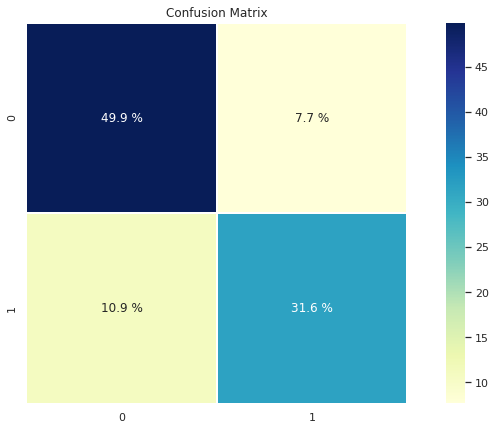

In [ ]:

sns.set()
fig, ax0 = plt.subplots(figsize = (14,7))

ax = sns.heatmap(data = cm, annot=True, fmt = '.1f', square=1, linewidths=.5, cmap="YlGnBu")
ax0.set_title('Confusion Matrix')
for t in ax.texts: t.set_text(t.get_text() + " %")
plt.show()

# 7. Submission

In [ ]:
# Applying the preprocessing steps to the X_test dataset
X_test = pd.DataFrame(X_test.text.apply(clean_data))
X_test = tokenizer.texts_to_sequences(X_test.text)
X_test = sequence.pad_sequences(X_test, maxlen= max_lenght, padding = 'post')

In [ ]:
# Predicting the results

predictions = saved_model.predict(X_test)

# Making the submission dataframe
X_submission = pd.read_csv('../input/nlp-getting-started/sample_submission.csv')
X_submission['target'] = np.round(predictions)
X_submission['target'] = X_submission['target'].astype(int)

In [ ]:
X_submission.to_csv('sub.csv', index = False)

# 8. Conclusions

**Results**

* For the validation set, the best model registered an accuracy of 81.53%. The confusion matrix indicates that 11.1% predictions were false positive. This indicates that a significant number of tweets are being classified as a disaster, even when they are normal tweets. When looking at the vocabulary, we can see that words that denote tragedies such as 'emergency' is one of the most common words for normal tweets, that can be a reason for such a high value.

* In the submission set, an accuracy of 80.2% was achieved


**Possible Improvements**
* Although the training and test datasets had features other than text, they were not used. The location feature has a lot of input errors, but with a good enough data cleanup, it could have been used to add information to the model.


* More complex neural network architectures can be used to improve the model. At the moment, a very simple architecture was employed, with only one layer of LSTM

* In addition to an improvement in the model, a more careful cleaning process can be used for the improvement. Handling of foreign language words is an example.

**References**

* [GloVe: Global Vectors for Word Representation](https://nlp.stanford.edu/projects/glove/)
*  [Deep Learning Methods for Text Data](https://towardsdatascience.com/understanding-feature-engineering-part-4-deep-learning-methods-for-text-data-96c44370bbfa)
* [How to Use Word Embedding Layers for Deep Learning with Keras](https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/)
* [Natural Language Processing in Python](https://www.youtube.com/watch?v=xvqsFTUsOmc)
* [Basic EDA Cleaning and Glove](https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove/input)
* [NLP With Disaster Tweets - EDA Cleaning and Bert](https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert#7.-Model)
* [Keras LSTM Tutorial](https://adventuresinmachinelearning.com/keras-lstm-tutorial/)